This **jupyter notebook** should be run within a **virtual environment, Python2 (w2p27)**.

Here's how to open the notebook from the terminal:

````
aubrey@aubrey-Latitude-7280:~/fix-bioassay-db$ workon w2p27
(w2p27) aubrey@aubrey-Latitude-7280:~/fix-bioassay-db$ jupyter notebook
````

# Imports

In [61]:
#%matplotlib inline
import pandas as pd
import sqlite3
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as ss
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
import subprocess
import re
import os.path

import lifelines
from lifelines import KaplanMeierFitter, statistics

#pd.options.display.max_rows = 8

# Utility Functions

In [62]:
def tex_escape(text):
    """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(unicode(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

# Database

In [63]:
dbpath = 'databases/storage.sqlite'
conn = sqlite3.connect(dbpath)

# List Bioassays

In [64]:
sql ="""
SELECT
    bioassay_name
FROM
    btl
GROUP BY bioassay_name
ORDER BY bioassay_name
"""
df = pd.read_sql_query(sql, conn)
pd.options.display.max_rows = 1000
df

,bioassay_name
0,None
1,DUG42-1
2,DUG42-2
3,MALB-1
4,MALB-2
5,MALBperOS-1
6,PNG-1
7,PNG-2
8,PNG-3
9,PNG-4


In [65]:
# Bioassay_name must be assigned a value from the data frame above.
# To generate a report which includes all replicates in a bioassay use a wild card, example: DUG42-%

#bioassay_name = 'V23B_large_bioassay-1'
#bioassay_name = 'DUG42-%'
bioassay_name = 'MALB-%'


title = bioassay_name.replace('-%', '')
title = tex_escape(title)

path_to_postmortem_images = 'uploads'
image_limit = 1000 # maximum number of post mortem images to include in report

# Summary Section

In [66]:
sql = """
SELECT
    *
FROM
    bioassay;
""".format(title)
df = pd.read_sql_query(sql, conn)
pd.options.display.max_rows = 1000
df

,id,name,tex
0,1,Vx23BperOS,\section{Laboratory experiment to evaluate the...
1,3,DUG42,\section{Description}\r\nAdult beetles incubat...
2,4,MALB,\section{Description}\r\n\r\n Adult beetles in...
3,5,PNG,\section{Description}\r\n Adult beetles incuba...
4,6,V23B,\section{Description}\r\n\r\n\r\n Adult beetle...
5,7,V23B_perOS-2,\section{Laboratory experiment to evaluate the...
6,8,V23B_perOSIN-1,Fifteen adult beetles maintained for more than...
7,9,Mal B perOSI-1,Fifteen adult beetles maintained for more than...
8,10,V23B -large bioassay test-1,Sixty adult beetles maintained for more than 2...


In [67]:
s = bioassay_name.split('-')[0]
try:
    summary = df[df.name==s].tex.values[0]
except:
    summary = 'Summary not available for "{}"'.format(s)
    summary = tex_escape(summary)
#print(summary)

In [68]:
summary_section_tex = r'''
\clearpage
\section{Summary}
---summary---
'''

summary_section_tex = summary_section_tex.replace('---summary---', summary)
#print(summary_section_tex)

# Mass Section

In [69]:
sql ="""
    SELECT 
        date_observed,
        date_start_bioassay,
        bioassay_treatment,
        julianday(date_observed) - julianday(date_start_bioassay) AS days,
        btl, mass
    FROM btl, obs
    WHERE
        btl.id = obs.btl
    AND
        bioassay_name LIKE '{}'
    AND mass IS NOT NULL
    ORDER BY btl, date_observed;
""".format(bioassay_name)
df = pd.read_sql_query(sql, conn)
pd.options.display.max_rows = 8
df

,date_observed,date_start_bioassay,bioassay_treatment,days,btl,mass
0,2019-01-18,2019-01-18,control,0.0,80,3140
1,2019-01-20,2019-01-18,control,2.0,80,3334
2,2019-01-21,2019-01-18,control,3.0,80,3578
3,2019-01-23,2019-01-18,control,5.0,80,3121
...,...,...,...,...,...,...
320,2019-02-10,2019-01-23,virus,18.0,124,3595
321,2019-02-12,2019-01-23,virus,20.0,124,3567
322,2019-02-14,2019-01-23,virus,22.0,124,3507
323,2019-02-16,2019-01-23,virus,24.0,124,3348


In [70]:
df['change_in_mass_per_day'] = df['mass'].diff()/df['days']
df = df[df.days>0]
pd.options.display.max_rows = 8
df

,date_observed,date_start_bioassay,bioassay_treatment,days,btl,mass,change_in_mass_per_day
1,2019-01-20,2019-01-18,control,2.0,80,3334,97.000000
2,2019-01-21,2019-01-18,control,3.0,80,3578,81.333333
3,2019-01-23,2019-01-18,control,5.0,80,3121,-91.400000
4,2019-01-25,2019-01-18,control,7.0,80,3099,-3.142857
...,...,...,...,...,...,...,...
320,2019-02-10,2019-01-23,virus,18.0,124,3595,-3.166667
321,2019-02-12,2019-01-23,virus,20.0,124,3567,-1.400000
322,2019-02-14,2019-01-23,virus,22.0,124,3507,-2.727273
323,2019-02-16,2019-01-23,virus,24.0,124,3348,-6.625000


In [71]:
# Remove outliers

percentile1 = df["change_in_mass_per_day"].quantile(0.01)
percentile99 = df["change_in_mass_per_day"].quantile(0.99)
original_row_count = df.shape[0]
df = df[df.change_in_mass_per_day.between(percentile1, percentile99)]
final_row_count = df.shape[0]
print('Removing outliers from the change_in_mass_per_day column')
print('Original row count: {}'.format(original_row_count))
print('Final row count: {}'.format(final_row_count))
print('Outliers removed: {}'.format(original_row_count - final_row_count))

Removing outliers from the change_in_mass_per_day column
Original row count: 294
Final row count: 288
Outliers removed: 6


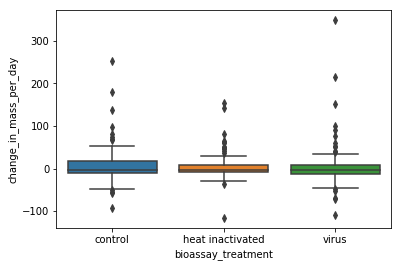

In [72]:
bp = sns.boxplot(x="bioassay_treatment", y="change_in_mass_per_day", data=df)
bp.figure.savefig('bp.pdf')

In [73]:
control = df[df.bioassay_treatment=='control'].change_in_mass_per_day.values
virus = df[df.bioassay_treatment=='virus'].change_in_mass_per_day.values
r = ss.kruskal(control, virus)
r

KruskalResult(statistic=0.5470895482322492, pvalue=0.45950934767237406)

In [74]:
mass_pairwise_results = sp.posthoc_dunn(df, val_col='change_in_mass_per_day', group_col='bioassay_treatment', p_adjust = 'holm')

In [75]:
mass_pairwise_results_tex = mass_pairwise_results.to_latex()
print(mass_pairwise_results_tex)

\begin{tabular}{lrrr}
\toprule
{} &   control &  heat inactivated &     virus \\
\midrule
control          & -1.000000 &          0.856799 &  0.856799 \\
heat inactivated &  0.856799 &         -1.000000 &  0.759809 \\
virus            &  0.856799 &          0.759809 & -1.000000 \\
\bottomrule
\end{tabular}



In [76]:
change_in_mass_section_tex = r'''
\clearpage
\section{Change in Mass}
Change in mass section goes here.

\begin{center}
     \includegraphics[width=\textwidth]{bp.pdf}
\end{center}

---mass pairwise results---
'''
# print(change_in_mass_section_tex)
change_in_mass_section_tex = change_in_mass_section_tex.replace('---mass pairwise results---', mass_pairwise_results_tex)
# print(change_in_mass_section_tex)

# Tex preamble, titlepage and TOC

In [77]:
preamble_tex = r'''
\documentclass[11pt]{scrartcl}
\usepackage{textcomp}
\usepackage{gensymb}
\usepackage{graphicx}
\usepackage{grffile} %required because there are multiple dot characters in my file names
\usepackage{booktabs}
\usepackage[letterpaper, margin=1in]{geometry}
        
\titlehead{\centering\includegraphics[width=0.75in]{static/images/crb_logo.png}\\
University of Guam Coconut Rhinoceros Beetle Biological Control Project\\
Bioassay Report generated by CRB Rearing Database v.20191027\\
https://aubreymoore.pythonanywhere.com/rearing}
\title{Bioassay Report: ---title---}
\author{Aubrey Moore and James Grasela\\University of Guam Coconut Rhinoceros Beetle Biocontrol Project}
'''

preamble_tex = preamble_tex.replace('---title---', title)
#print(preamble_tex)

In [78]:
titlepage_tex = r'''
\begin{titlepage}
    \maketitle
    \tableofcontents
\end{titlepage}
'''

#print(titlepage_tex)

# Mortality Section

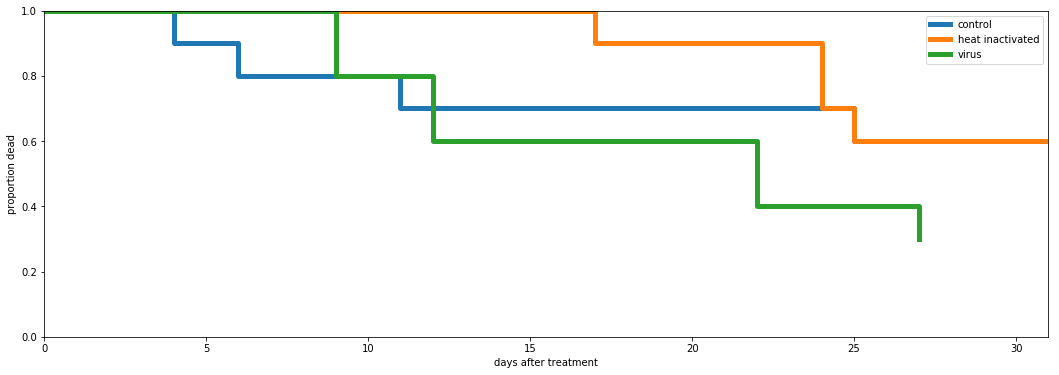

In [79]:
sql = "SELECT * FROM btl WHERE bioassay_name LIKE '{}'".format(bioassay_name)
df = pd.read_sql_query(sql, conn)    
#print(df)

t, e = lifelines.utils.datetimes_to_durations(
    start_times=pd.to_datetime(df.date_start_bioassay),
    end_times=pd.to_datetime(df.date_died),
    fill_date=pd.to_datetime(df.date_end_bioassay))
df['t'] = t
df['e'] = e

# Create survorship plot
fig, ax = plt.subplots(figsize=(18,6))
kmf = KaplanMeierFitter()
for name, grouped_df in df.groupby('bioassay_treatment'):
    kmf.fit(grouped_df['t'], grouped_df['e'], label=name)
    kmf.plot(ax=ax, linewidth=5, ci_show=False)
ax.set_xlabel('days after treatment')
ax.set_ylabel('proportion dead')
ax.set_ylim([0,1])
fig.savefig('survivorshipfig.pdf')

# Create motality-table-tex
results = statistics.pairwise_logrank_test(df['t'], df['bioassay_treatment'], df['e'])
s = r'''
    \begin{table}[h!]
    \centering
    \caption{Pairwise differences among mortality curves.}
'''
s += results.summary.to_latex()
s += '\end{table}'
mortality_pairwise_table_tex = s
#print(s)

In [80]:
sql = """
SELECT 
    bioassay_treatment, COUNT(*) AS ntotal
FROM
    btl
WHERE 
    bioassay_name LIKE '{}'
GROUP BY bioassay_treatment
ORDER BY bioassay_treatment;
""".format(bioassay_name)    
df_total = pd.read_sql_query(sql, conn)    
df_total

,bioassay_treatment,ntotal
0,control,10
1,heat inactivated,10
2,virus,10


In [81]:
sql = """
SELECT 
    bioassay_treatment, COUNT(*) AS ndead
FROM
    btl
WHERE 
    bioassay_name LIKE '{}'
AND
    date_died IS NOT NULL
GROUP BY bioassay_treatment
ORDER BY bioassay_treatment;
""".format(bioassay_name)    
df_dead = pd.read_sql_query(sql, conn)    
df_dead

,bioassay_treatment,ndead
0,control,4
1,heat inactivated,4
2,virus,7


In [82]:
def fisher(r, cdead, calive):
    return ss.fisher_exact([ [r.ntotal-r.ndead, r.ndead], [calive, cdead]])[1]

# Treatment mortality is adjusted for control mortality
# See http://www.ehabsoft.com/ldpline/onlinecontrol.htm

df = df_total.merge(df_dead)
df['mortality'] = df.ndead/df.ntotal
control_mortality = df[df.bioassay_treatment=='control'].mortality.values[0]
df['adjusted_mortality'] = (df.mortality-control_mortality)/(1-control_mortality)
ctotal = df[df.bioassay_treatment=='control'].ntotal
cdead = df[df.bioassay_treatment=='control'].ndead
calive = ctotal-cdead
df['significance'] = df.apply(fisher, axis=1, cdead=cdead, calive=calive)
mortality_table_tex = df.to_latex()
df

,bioassay_treatment,ntotal,ndead,mortality,adjusted_mortality,significance
0,control,10,4,0.4,0.0,1.00000
1,heat inactivated,10,4,0.4,0.0,1.00000
2,virus,10,7,0.7,0.5,0.36985


In [83]:
mortality_section_tex = r'''
\clearpage
\section{Mortality}

---mortality_table_tex---

\begin{center}
     \includegraphics[width=\textwidth]{survivorshipfig.pdf}
\end{center}


---mortality_pairwise_table_tex--- 
'''

mortality_section_tex = mortality_section_tex.replace('---mortality_table_tex---', mortality_table_tex)
mortality_section_tex = mortality_section_tex.replace('---mortality_pairwise_table_tex---', 
                                                      mortality_pairwise_table_tex)
#print(mortality_section_tex)

# Post mortem images section

In [84]:
def get_postmortem_images(bioassay_name_pattern, image_limit):
    """
    """
    
    # get data
    
    sql = """
    SELECT id, bioassay_name, bioassay_treatment, pm_image
    FROM btl
    WHERE bioassay_name LIKE '{}' 
        AND pm_image IS NOT NULL AND pm_image != ''
    LIMIT {};
    """.format(bioassay_name_pattern, image_limit)
    df = pd.read_sql_query(sql, conn) 
    #rows = db.executesql(sql, as_dict=True)
    #df = pd.DataFrame(rows)
    df.dropna(inplace=True)
    if df.empty:
        tex = r'No post mortem images have been uploaded for this bioassay.' + '\n'
        return tex

    # generate tex
    
    tex = ''
    for treatment in df.bioassay_treatment.unique():
        tex += r'\subsection{' + treatment + r'}' + '\n\n'
        for index, row in df[df.bioassay_treatment==treatment].iterrows():
            fname = '{}/{}'.format(path_to_postmortem_images, row.pm_image)
            if os.path.isfile(fname): 
                tex += r'\begin{figure}[h!]' + '\n'
                tex += r'    \centering' + '\n'
                tex += r'    \includegraphics[width=\linewidth, height=\textheight, keepaspectratio]{' + fname + r'}' + '\n'
                tex += r'    \caption{Bioassay: ' + row.bioassay_name + '; Treatment: ' + row.bioassay_treatment + r'; Beetle ID: ' + str(row.id) + r'}' + '\n'
                tex += r'\end{figure}' + '\n'
            else:
                tex += r'ERROR: ' + fname + r' does not exist.' + '\n'
                print('{} does not exist.'.format(fname))
            tex += r'\clearpage' + '\n\n'
    return tex

#print get_postmortem_images(bioassay_name, 1000)

In [85]:
post_mortem_section_tex = r'''
\clearpage
\section{Post Mortem Images}
---post_mortem_section---
'''

post_mortem_section_tex = post_mortem_section_tex.replace('---post_mortem_section---', 
                                                          get_postmortem_images(bioassay_name, image_limit))
                                                          
#print(post_mortem_section_tex)

# Generate PDF

In [86]:
# Write report.tex
# I wrote it like this so that sections can easily be disabled by commenting out with a #

s = preamble_tex
s += r'\begin{document}'
s += titlepage_tex
s += summary_section_tex
s += mortality_section_tex
s += change_in_mass_section_tex
s += post_mortem_section_tex
s += r'\end{document}'
#print(s)

with open('report.tex', "w") as f:
    f.write(s)

In [87]:
# Generate PDF

result = subprocess.call(['pdflatex', 'report.tex'])
result = subprocess.call(['pdflatex', 'report.tex'])
#result = subprocess.call(['xdg-open', 'report.pdf'])
#return response.stream('report.pdf')

In [88]:
# Compress PDF and save in file named "bioassay-title.pdf"
outputfile = 'bioassay-{}.pdf'.format(title)
subprocess.call(['gs',
                 '-sDEVICE=pdfwrite',
                 '-dPrinted=false',
                 '-dCompatibilityLevel=1.4',
                 '-dPDFSETTINGS=/ebook',
                 '-dNOPAUSE',
                 '-dQUIET', 
                 '-dBATCH',
                 '-sOutputFile={}'.format(outputfile),
                 'report.pdf'])

0

In [89]:
result = subprocess.call(['xdg-open', 'report.pdf'])